<a href="https://colab.research.google.com/github/StefanKDS/TitanicSurvivalRegression/blob/master/TitanicSurvival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load data from Kaggle

To download something from Kaggle via API you need a token from Kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# Install kaggle and import data
!pip install kaggle
!kaggle competitions download -c titanic

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 31.4MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 62.8MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.28MB/s]


# Prepare the data for using in our models

In [3]:
# Read in the insurance dataset
train_data = pd.read_csv("train.csv")
train_data.head

<bound method NDFrame.head of      PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0              1         0       3  ...   7.2500   NaN         S
1              2         1       1  ...  71.2833   C85         C
2              3         1       3  ...   7.9250   NaN         S
3              4         1       1  ...  53.1000  C123         S
4              5         0       3  ...   8.0500   NaN         S
..           ...       ...     ...  ...      ...   ...       ...
886          887         0       2  ...  13.0000   NaN         S
887          888         1       1  ...  30.0000   B42         S
888          889         0       3  ...  23.4500   NaN         S
889          890         1       1  ...  30.0000  C148         C
890          891         0       3  ...   7.7500   NaN         Q

[891 rows x 12 columns]>

In [4]:
# Do we have missing data ?
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# Fill missing values
train_data["Age"] = train_data["Age"].replace(np.NaN, train_data["Age"].mean())
train_data["Cabin"] = train_data["Cabin"].fillna('U')
train_data["Embarked"] = train_data["Embarked"].fillna('U')

In [6]:
# Do we have still missing data ?
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [7]:
# Prepare data
ct = make_column_transformer(
    (MinMaxScaler(), ["Pclass", "Age", "SibSp", "Parch", "Fare"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["Sex", "Ticket", "Embarked"]))

# Drop not needed columns
train_data = train_data.drop(["Name", "PassengerId"], axis=1)

# Create X & y values
X = train_data.drop("Survived", axis=1)
y = train_data["Survived"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal = X_train_normal.toarray()
X_test_normal = X_test_normal.toarray()

# Model 1: Dense Model
First we create a simple base model with 3 Dense layers

In [8]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', min_lr=0.0001, patience=5, verbose=1)
early_stopping = EarlyStopping(patience=20, monitor='val_accuracy')
callbacks = [early_stopping,reduce_lr]

# Set random seed
tf.random.set_seed(42)

# Build the model (2 layers, 250, 1 units)
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(250, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_1.compile(loss = 'binary_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
                          metrics=['accuracy'])

In [9]:
# Fit the model
history = model_1.fit(X_train_normal, y_train, epochs=100, callbacks=callbacks, validation_data=(X_test_normal, y_test))

Epoch 1/100
23/23 [==============================] - 2s 13ms/step - loss: 0.9992 - accuracy: 0.6952 - val_loss: 0.4378 - val_accuracy: 0.7933 - lr: 0.2000
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 0.2625 - accuracy: 0.8567 - val_loss: 0.5318 - val_accuracy: 0.8045 - lr: 0.2000
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 0.1243 - accuracy: 0.9438 - val_loss: 0.4349 - val_accuracy: 0.8156 - lr: 0.2000
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0784 - accuracy: 0.9775 - val_loss: 0.4161 - val_accuracy: 0.8045 - lr: 0.2000
Epoch 5/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0581 - accuracy: 0.9803 - val_loss: 0.4453 - val_accuracy: 0.8436 - lr: 0.2000
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0495 - accuracy: 0.9846 - val_loss: 0.4922 - val_accuracy: 0.7374 - lr: 0.2000
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.

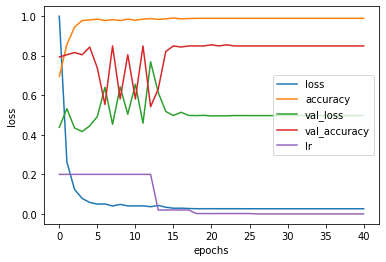

INFO:tensorflow:Assets written to: models/model1/assets


In [10]:
!mkdir models

np.save('models/history.npy', history.history)

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

model_1.save('models/model1')

# Model 2: Random ForestClassifier

In [12]:
# Train the model
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(max_depth=100, random_state=1)
model2.fit(X_train_normal, y_train)

model2.score(X_test_normal, y_test)

0.8324022346368715

## Model 3: Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
model3 = LogisticRegression(random_state=0)
model3.fit(X_train_normal, y_train)


LogisticRegression(random_state=0)

In [15]:
predictions = model3.predict(X_test_normal)

In [16]:
score = model3.score(X_test_normal, y_test)
print(score)

0.8156424581005587
